# PCA example over Gulf Stream: getting the PCs and re-shaping the data

In this notebook we can find the code needed to perform a Principal Component Analysis over the seasonal cycle, using data form ARMOR 3D. The python library used is the scikit-learn library. This analysis is performed over the Gulf Stream region, but it can be eaasily extended to the complete Atlantic region. Due to compatibility rpblems with cartopy library on this server (using https://collab.umr-lops.fr/app/notebooksq) an external notebook is devoted to generate the plot and respective animation of the spatial distribution of the first 4 PCs. This notebook can be found [here](./PCs-Maps.ipynb) 

This notebook has the following structure:

   [1. Imported modules](#1.-Imported-modules)
   
   [2. Dictionaries used](#2.-Dictionaries-used)
   
   [3. Functions](#3.-Functions)
   
   [4. Implementation](#4.-Implementation)

## 1. Imported modules

In [1]:
from sklearn.decomposition import PCA
from sklearn.utils import safe_mask
from sklearn.impute import SimpleImputer
from sklearn import preprocessing


import xarray as xr
import numpy as np
from numpy import ma

import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.animation as animation
from IPython.display import HTML


import warnings; warnings.simplefilter('ignore')

## 2. Dictionaries used

In [2]:
# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-40, 40.),
        'lat' : (65, 85),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 15.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

## 3. Functions

In [3]:
## Function to crop the dataset
def Crops(coord, data_set, dic):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        data_set : DataArray
            Dataset to be cropped
            
        dic : text
            Dictionarie's name.
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = dic[coord]['lon']
    lat1, lat2 = dic[coord]['lat']
    
    new_ds = data_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)




def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)


def Normalize(data_set):
    mn = data_set.min(dim='week', skipna=True)
    mx = data_set.max(dim='week', skipna=True)
    
    y = (data_set - mn) / (mx - mn)
    return y


def Re_arrange(data_set, years):
    """
        Re_arrange is a function that arranges a dataset from a 
        n years time series into a 1 year timeseries. 
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to re-arrange.
            
        years : list
            List of the years numbers to transform.


        Output:
        -------
        g : List
            List of the new arrays.
    """
    
    g = []

    for i,y in enumerate(years):
        aa = points.sel(time=points.time.dt.year==y)
        aa = aa.groupby('time.week').mean(dim='time', skipna=True)

        aa = aa.sel(week=slice(1,52))
        g.append(aa)
        del aa

    return(g)



def Shift(data_set):
    max_w = data_set.groupby('point').argmax(dim='week', keep_attrs=True, skipna=True).values
    r = 26 - max_w 
    
    data = data_set.T.values
    del data_set
    
    rows, column_indices = np.ogrid[:data.shape[0], :data.shape[1]]
    r[r < 0] += data.shape[1]
    column_indices = column_indices - r[:, np.newaxis]
    shft = data[rows, column_indices]
    shift = xr.DataArray(shft.T, dims=['week', 'point'], name='mlotst')

    return(shift)

## 4. Implementation

This example is done over a small region, the Gulf Stream.

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../New_ARMOR/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_of = '/home/lgarcia/Documents/Other_datasets/'
dir_oi = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

In [5]:
## Adding time stamps to the dataset

d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

Using all the grid points, except for the ones in the shallow ocean ($h<2000$m)

In [6]:
coord = 'gul'
region = Crops(coord, c_armor1, reg_ext)
region2 = Crops(coord, c_armor15, reg_ext)

region2 = Masking(region2, region2.to[0,25])

In [7]:
## Getting the grid point in which the PCA is performed, here all are taken

points = region.mlotst.where(region2.mask==1)   #[:,::4,::4]

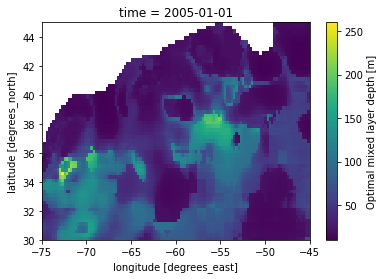

In [8]:
## Just to see the area used

%matplotlib inline
points[0].plot()
plt.show()

### 4.1 Re-shaping the dataset: 

The analysis ignores the 2018 because is not complete. In this version, the data is not shifted. Therefore we have the maximum of the MLD approximately in the 10th week. If the shift is performed, the maximum is located at the meiddle of the year (at week 26).

In [9]:
## Here we create the list of the years we want to work: 2005-2017.
## Then the dataset is re-shaped, and a xarray.
## Shape of the data goes from ()

years = [y for y in range(2005, 2018)]


nn = Re_arrange(points, years)
new_points = xr.concat(nn, dim='year')

In [10]:
## Old shape of the dataset
## (years*weeks, latitude, longitude)
points.shape

(729, 60, 120)

In [11]:
## New shape of the dataset
## (years, weeks, latitude, longitude)
new_points.shape

(13, 52, 60, 120)

#### 4.1.1 Re-shape to 2D

Basically, here we want to get rid of the (lon, lat) structure of the data, but conservating the order. This is because later we will re-shape the output data to obtain, again, the (lon, lat) structure.

In [12]:
## The values of each variable

lat = new_points['latitude'].values
lon = new_points['longitude'].values
mld = new_points.values

In [13]:
## Original dataset shape
## (year, week, lat, lon)

mld.shape

(13, 52, 60, 120)

In [14]:
## Here we exchange the year -> week index
## new shape (week, year, lat, lon)

mld = np.moveaxis(mld, 0, 1)

In [15]:
## Un-packing the mld values in a new numpy array. New shape:
## (week, year*lat*lon)

X = np.reshape(mld, (mld.shape[0], mld.shape[1]*len(lat) * len(lon)), order='F')
X.shape

(52, 93600)

#### 4.1.2 Masking the land grid points

The first thing is to create a mask for the ocean grid points.

In [16]:
X2 = np.ma.masked_array(X, np.isnan(X))

In [17]:
land = X2.sum(0).mask

In [18]:
## Mask of ocean (lat, lon)
## we will use it later

ocean = ~land

#### 4.1.3 Getting rid of the missing values

In [19]:
## Here we pre-process the original data, so we can deal with the nan
## values. The strategy here is to replace the missing values with the
## mean of the dataset.

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)

X3 = imp.transform(X)

In [20]:
X3.shape

(52, 78416)

#### 4.1.4 This is a way to normalize the data

In [21]:
## The normalized array Xn can be used to calculate the PCs
## I did not normalize the data!

#scaler  = preprocessing.StandardScaler()
#scaler_sst = scaler.fit(X3)

In [22]:
#Xn = scaler_sst.transform(X3)

In [23]:
#print(Xn.std(), Xn.mean())

### 4.2 Performing PCA

In [24]:
## Run the PCA analysis: 12 PCs

n_components = 12  # Rq: n_components cannot exceed ncols !
pca = PCA(n_components=n_components)

In [25]:
## eigenvectors,i.e, the loadings

pca = pca.fit(X3.T)

In [26]:
## Loadings: their shape 

pca.components_.shape

(12, 52)

In [27]:
#· Principal components :: make the projection 

reduced_values = pca.transform(X3.T)
reduced_values.shape

(78416, 12)

### 4.3 Preparing a new data array with the results: Loadings

In [28]:
samp = reduced_values.shape[0]
eof = reduced_values.shape[1]
w = new_points.week.size

data = np.zeros((samp,eof,w))

result = xr.DataArray(data, dims=['point', 'prin_comp', 'week'], name="fake_data")

In [29]:
result['reduced_data'] = xr.DataArray(reduced_values, dims=['point', 'prin_comp'])

result['loadings'] = xr.DataArray(pca.components_, dims=['prin_comp', 'week'], 
                                  attrs={'comment': 'Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.'})
result['explained_variance'] = xr.DataArray(pca.explained_variance_ratio_*100, 
                                        dims=['prin_comp'], attrs={'comment': 'Percentage of variance explained by each of the selected components'})

#### 4.3.1 Plotting the loadings

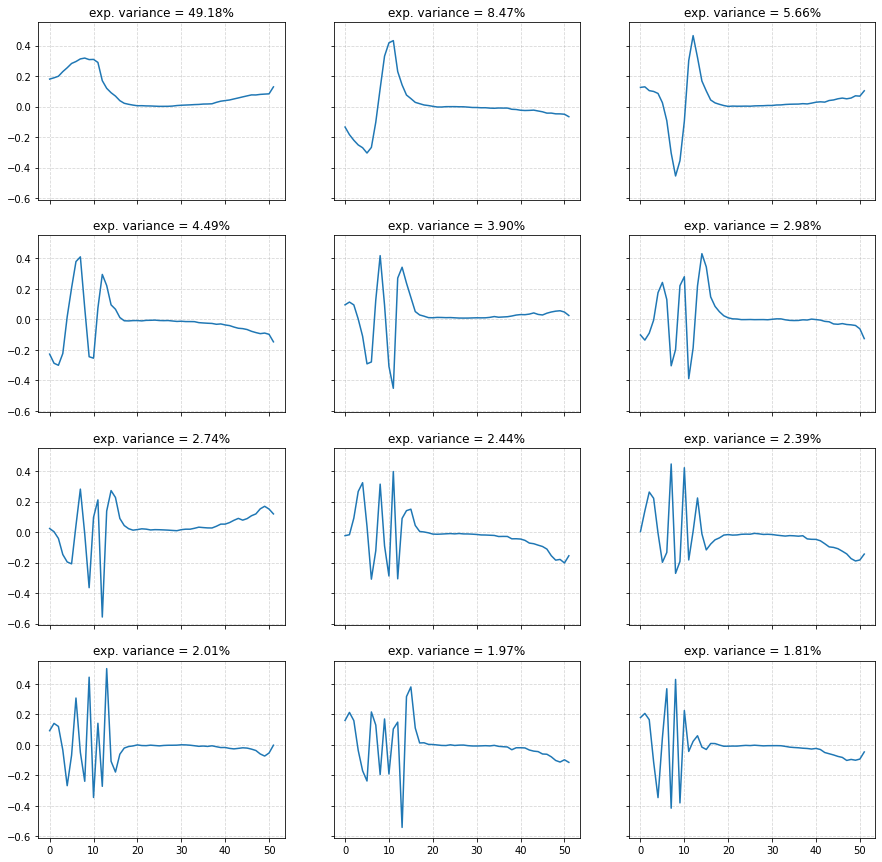

In [30]:
n_cols = 3
n_rows = 4

coeff = 0

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,15), sharex=True, sharey=True)

for i in range(n_rows):
    for j in range(n_cols):
        y = result['loadings'][coeff]

        ev = str('{:.2f}'.format(result['explained_variance'][coeff].values))
        name = 'exp. variance = ' + ev + '%'
        
        ax[i,j].plot(y) 
        ax[i,j].set_title(name)    
        ax[i,j].grid(linestyle='--', alpha=0.5)
        coeff += 1

plt.show()

#### 4.3.2 Explained variance of the eigenvalues

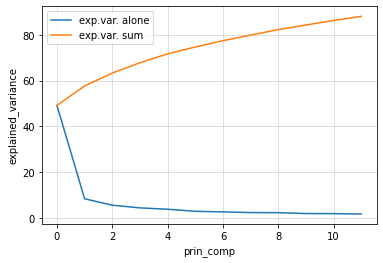

In [31]:
result['explained_variance'].plot(label='exp.var. alone')
result['explained_variance'].cumsum(dim='prin_comp').plot(label='exp.var. sum')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

#### 4.3.3 Plot of the data projected over the PC space

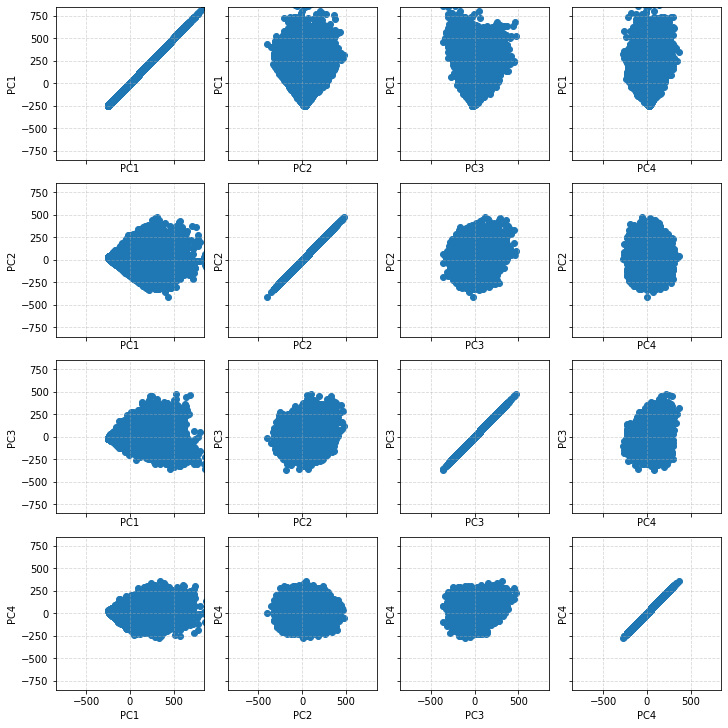

In [32]:
ncols = 4
nrows = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10), sharex=True, sharey=True, constrained_layout=True)

for i in range(nrows):
    for j in range(ncols):
        x = result['reduced_data'][:,j]   #PC[j]
        y = result['reduced_data'][:,i]   #PC[i]
        
        pc_x = 'PC' + str(j+1)
        pc_y = 'PC' + str(i+1)

        ax[i,j].scatter(x, y)

        ax[i,j].set_xlabel(pc_x)
        ax[i,j].set_ylabel(pc_y)
        ax[i,j].grid(linestyle='--', alpha=0.5)
        

plt.xlim(-850., 850)
plt.ylim(-850., 850)

plt.show()

### 4.4 Reconstruction: recovering (lat, lon) structure

In [33]:
## Creating an array with the shape of the region*years, and 
## checking that the size is the correct

EOF_recons = np.ones((n_components, mld.shape[1] * len(lat) * len(lon))) * -999.
EOF_recons.shape

(12, 93600)

In [34]:
## Appending the projections in the reconstructed array, 
## along  with the mask of the ocean

for i in range(12): 
    EOF_recons[i,ocean] = reduced_values[:,i]

In [35]:
## Givinf to reconstructed array the final shape. It will have
## (pc, year, lat, lon)

EOF_recons = ma.masked_values(np.reshape(EOF_recons, (n_components, mld.shape[1], len(lat), len(lon)), order='F'), -999.)

In [36]:
## Exchanging the year and pc axes. The new shape is
## (year, pc, lat, lon)

EOF_recons = np.moveaxis(EOF_recons, 0, 1)

In [37]:
## Getting the shape of the reconstructed array

year = EOF_recons.shape[0]
PC = EOF_recons.shape[1]
la = EOF_recons.shape[2]
lo = EOF_recons.shape[3]

## Array of zeros with the shape of reconstructed data

fkdt = np.zeros((year,PC,la,lo))

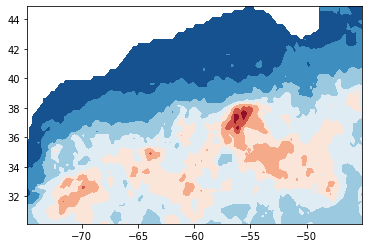

In [38]:
## Just checking that the plot gives the correct map, and
## making a lon, lat mesh for the plot

lons, lats = np.meshgrid(lon, lat)
plt.contourf(lons, lats, EOF_recons[0,0],cmap=plt.get_cmap('RdBu_r'))

#### 4.4.1 Preparing the data array for the reduced values:: mappingg purpose and saving dataset

In [39]:
## The shape here is
## (years, PC, lat, lon)

EOF_recons.shape

(13, 12, 60, 120)

In [40]:
## Creating a xarray to save the rseult

EOF = xr.DataArray(fkdt, dims=['years', 'prin_comp', 'latitude', 'longitude'], name="fake_data")

In [41]:
## Getting the values of the coordinates of the new data array EOF

lats = points.latitude.values
lons = points.longitude.values
pcs = np.arange(n_components)


d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2017,12,20)

years = pd.date_range(start=d1, end=d2, freq='AS')

In [42]:
## Giving the coordinates to the new data array EOF

EOF.coords['years'] = (('years'), years)
EOF.coords['latitude'] = (('latitude'), lats)
EOF.coords['longitude'] = (('longitude'), lons)
EOF.coords['prin_comp'] = (('prin_comp'), pcs)

In [43]:
## Just checking that EOF is rigth

EOF

<xarray.DataArray 'fake_data' (years: 13, prin_comp: 12, latitude: 60, longitude: 120)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ...,

#### 4.4.2 Saving the EOF data array

In [44]:
## Giving EOF the values

EOF['reduced_data'] = xr.DataArray(EOF_recons, dims=['years', 'prin_comp', 'latitude', 'longitude'])

In [46]:
## Saving EOF in a external file

new_filename = '../../Other_datasets/PCA_projections.nc'
print ('saving to ', new_filename)

## Un comment this lines to save the file!

EOF.to_netcdf(path=new_filename)
print ('finished saving')

saving to  ../../Other_datasets/PCA_projections.nc
finished saving
